# Модель ракеты
Данная модель может описать реактивное движение ракеты с учётом расхода топлива (уравнение Мещерского) и изменения в ускорении свободного падения в зависимости от расстояния от тела до поверхности Земли (если изменить постоянные, можно сделать то же самое для других планет).

### Уравнение Мещерского для силы реактивного движения
$$\vec{F}(t) = \frac{dm}{dt}\vec{u} \text{ , где u - относительная скорость истечения газа.}$$

### Сила тяжести
$$F = \frac{GmM_{З}}{(R_{З} + y)^{2}}$$

In [1]:
import numpy as np

DT = 0.001 # Приращение времени
G = 6.6743 * 10**(-11) # Гравитационная постоянная
EARTH_MASS = 5.972 * 10**24
EARTH_RADIUS = 6.371 * 10**6

In [2]:
class Body:
    def __init__(self, x, y, mass, **kwargs):
        """
        Создать тело.
        
        Обязательные параметры:
        ----------
        x: float
            горизонтальная координата
        y: float
            вертикальная координата
        mass: float
            масса тела
        
        Дополнительные параметры:
        ----------
        px: float
            горизонтальная составляющая импульса
        py: float
            вертикальная составляющая импульса
        """

        self.x = x
        self.y = y
        self.mass = mass

        self.px = 0.0
        self.py = 0.0
        whitelist = ['px', 'py']
        for k, v in kwargs.items():
            if k in whitelist:
                self.setattr(self, k, v)
            else:
                raise KeyError("Invalid keyword parameter " + v)

        self.fx = 0.0
        self.fy = 0.0
        
        self.trajectory_x = []
        self.trajectory_y = []

    def advance(self):
        """
        Выполнить шаг математической модели и записать координаты для составления траектории.
        """
        
        if self.y >= 0: # Остановить движение при нуле.
            self.x += self.px / self.mass
            self.y += self.py / self.mass
        
        self.px += self.fx * DT
        self.py += self.fy * DT
        
        self.fy -= G * self.mass * EARTH_MASS / (EARTH_RADIUS + self.y)**2

        self.trajectory_x.append(self.x)
        self.trajectory_y.append(self.y)

In [3]:
class Rocket(Body):

    def __init__(self, x, y, rocket_mass, fuel_mass, dm, u, phi, dphi):
        """
        Создать ракету.
        
        Пареметры:
        ----------
        x: float
            горизонтальная координата
        y: float
            вертикальная координата
        rocket_mass: float
            масса ракеты (не включая топливо)
        fuel_mass: float
            масса топлива
        dm: float
            расход топлива за единицу времени dt
        u: float
            относительная скорость истечения газа из ракеты
        phi: float
            угол между ракетой и осью x
        dphi: float
            изменение угла между ракетой и осью x за единицу времени dt
        """
        
        super().__init__(x, y, rocket_mass + fuel_mass) # Вызовем конструктор предка — тела, т.к. он для ракеты актуален
        
        self.rocket_mass = rocket_mass
        self.fuel_mass = fuel_mass
        self.dm = dm
        self.u = u
        self.phi = phi
        self.dphi = dphi

    def __burn_fuel(self):
        """
        Внутренний метод для расчёта последствий воздействия внутренних сил ракеты (в первую очередь, реактивное движение).
        """

        f = self.dm/DT * self.u
        fx = f * np.cos(self.phi)
        fy = f * np.sin(self.phi)

        self.fx = fx
        self.fy = fy
        self.mass -= self.dm
        self.phi += self.dphi # Положим, ракета поворачивается.

    def advance(self):
        """
        Выполнить шаг математической модели и записать координаты для составления траектории.
        """
        
        if self.mass != self.rocket_mass:
            self.__burn_fuel()

        super().advance() # вызовем метод предка — тела, т.к. и он для ракеты актуален.

In [4]:
rocket1_stats = {
    'x': 0,
    'y': 0,
    'rocket_mass': 3 * 10**5,
    'fuel_mass': 2.5 * 10**5,
    'dm': 100,
    'u': 4000,
    'phi': np.pi/2,
    'dphi': -0.0002,
}

rocket2_stats = {
    'x': 4 * 10**6,
    'y': 0,
    'rocket_mass': 3 * 10**3,
    'fuel_mass': 2.5 * 10**3,
    'dm': 20,
    'u': 900,
    'phi': np.pi/1.6,
    'dphi': +0.00001,
}

In [5]:
rocket1 = Rocket(**rocket1_stats)
rocket2 = Rocket(**rocket2_stats)

bodies = [rocket1, rocket2]

for b in bodies:
    for t in np.arange(0, 10, DT):
        b.advance()
    # Делим на 1000, чтобы выразить в километрах
    b.trajectory_x = list(map(lambda x: x / 1000, b.trajectory_x))
    b.trajectory_y = list(map(lambda y: y / 1000, b.trajectory_y))

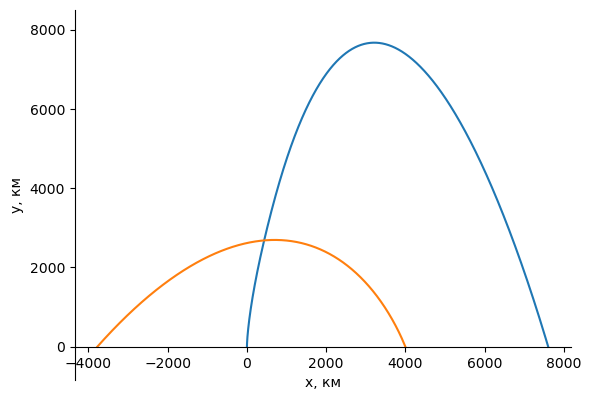

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('data', 0.0))
ax.axis('equal')
for b in bodies: # для всех тел
    ax.plot(b.trajectory_x, b.trajectory_y) # нарисуем их траектории
    ax.set(xlabel="x, км", ylabel="y, км")